#  ПРОГНОЗИРОВАНИЕ ЗАКАЗОВ ТАКСИ

# Краткое описание проекта.

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

# Цель проекта.

Построить модель для такого предсказания.
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# План проекта.

- Изучение и подготовка данных.
- Анализ данных.
- Обучение нескольких моделей.
- Тестирование лучшей модели.
- Общий вывод.

## Изучение и подготовка данных.

Импортируем все необходмые для исследования библиотеки и метрики.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from catboost import CatBoostRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
import warnings 
warnings.filterwarnings('ignore')

Считаем данные из csv-файла в датафрейм и сохраним в переменной data. Назначим первый столбец в качестве индекса.Выведем первые 5 строчек датафрейма на экран.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**интервал временного ряда составляет 10 минут.**

Выведем общую информацию по датафрейму

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индекс таблицы.

In [4]:
data.sort_index(inplace=True)

Проверим в хронологическом ли порядке расположены даты и время. Воспользуемся функцией is_monotonic.

In [5]:
display(data.index.is_monotonic)

True

Поменяем интервал временного ряда.Согласно заданию выполним ресемплирование по одному часу. После группировки вызовем функции sum() для агрегации значений. Построим график.

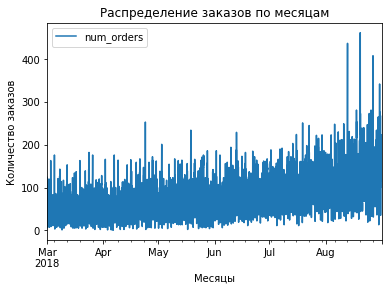

In [6]:
data = data.resample('1H').sum()
data.plot()
plt.title("Распределение заказов по месяцам")
plt.xlabel("Месяцы")
plt.ylabel("Количество заказов");

**Выводы:**
- датафрейм состоит из двух столбцов:datetime(дата и время) и num_orders(количество заказов). Целевым признаком является столбец с количеством заказов.
- данные собраны за 6 месяцев с 00:00:00 1 марта 2018 года по 23:30:00 31 августа 2018 года.
- интервал временного ряда составляет 10 минут.

## Анализ

**Чтобы лучше понимать временной ряд, разберём тренды и сезонность.**

Разложим временной ряд на тренд и сезонную компоненту

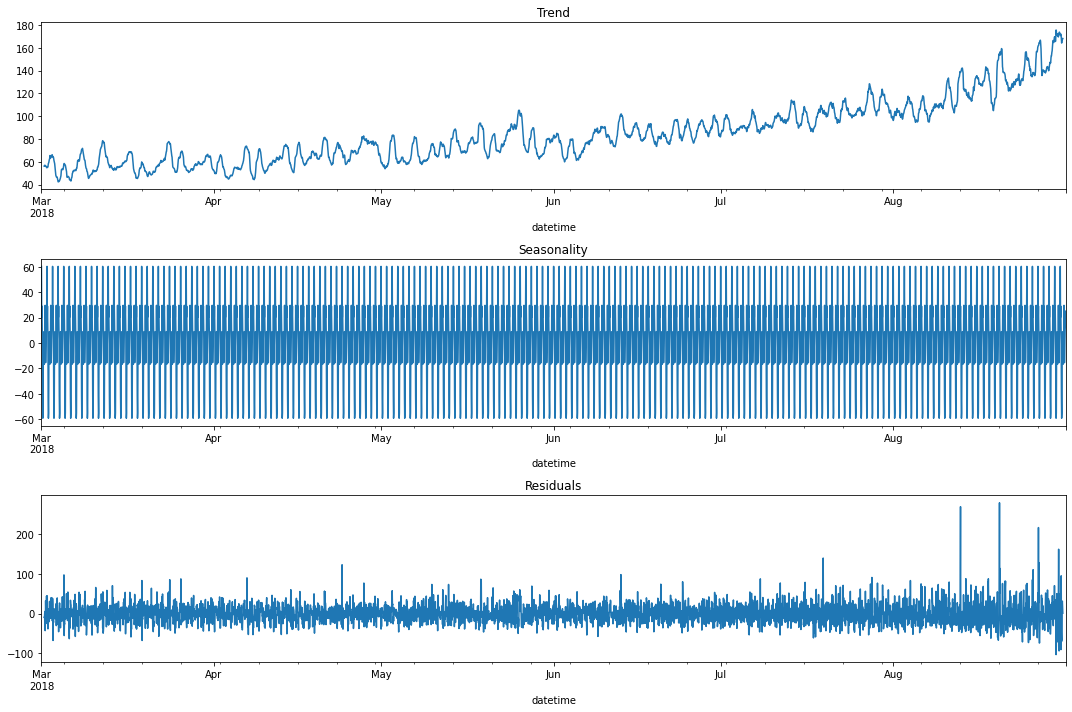

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


**Со временем количество заказов растет. Связываю это с тем, что бизнес развивается и дела идут в гору.Сезонность мы посмотреть не может, так как данные собраны только за полгода.
В целом графики плохо читаемые, слишком высокая частота. Зададим интервал в 15 дней и посмотрим на них снова.**

Взглянем на суточную сезонность. Возьмем данные за пару дней.

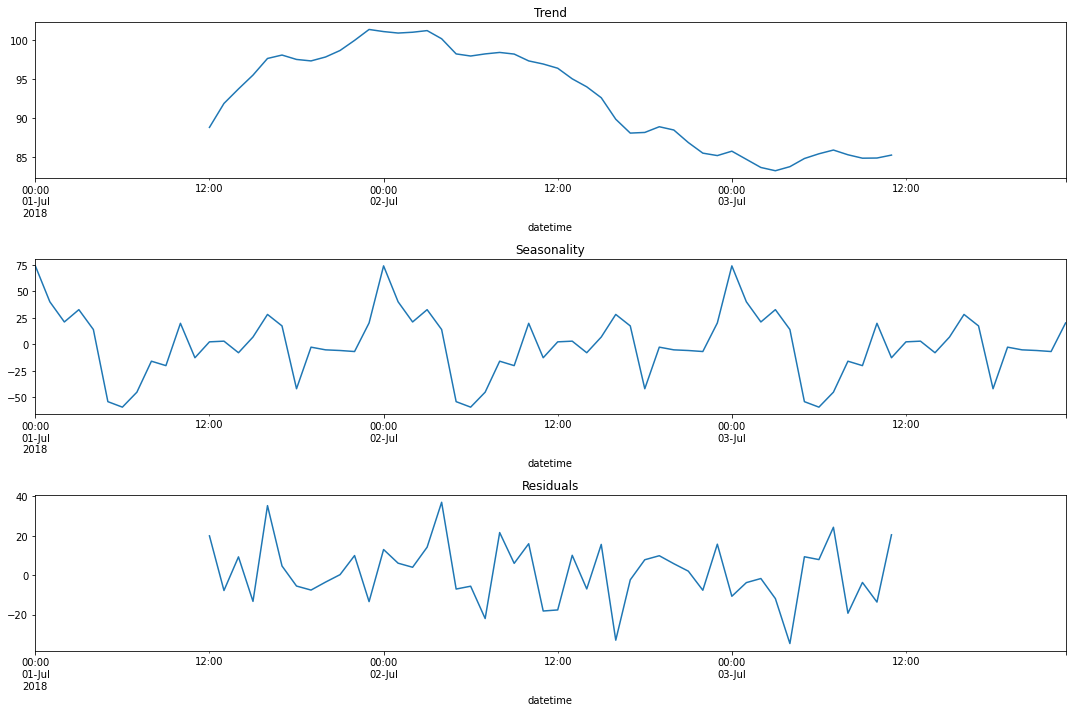

In [8]:
decomposed_1 = seasonal_decompose(data['2018-07-01':'2018-07-03'])

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed_1.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_1.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_1.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику сезонности отлично видно, что пики вызовов такси приходятся на ночные часы, а спад наблюдается в районе 9-10 часов,когда начинается рабочий день.

Возьмем данные с 1 по 15 июля.

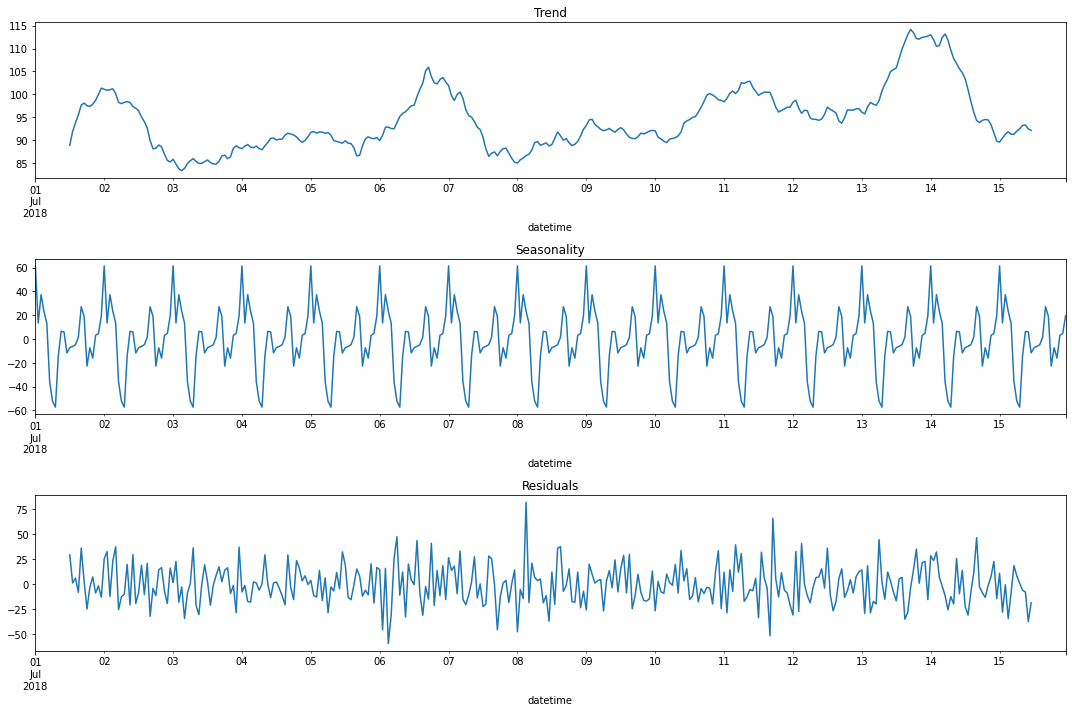

In [9]:
decomposed_2 = seasonal_decompose(data['2018-07-01':'2018-07-15'])

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed_2.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Четко просматриваются всплески по заказам в выходные дни.**

Воспользуемся тестом Дики-Фуллера для того, чтобы определить, приводим ли наш ряд к стационарному.Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный

In [10]:
ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Наш ряд стационарный


## Обучение

Для начала создадим признаки для горизонта прогнозирования в один шаг.
Напишем функцию для создания календарных признаков,вычислим отстающие значения и скользящее среднее.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 168, 24)

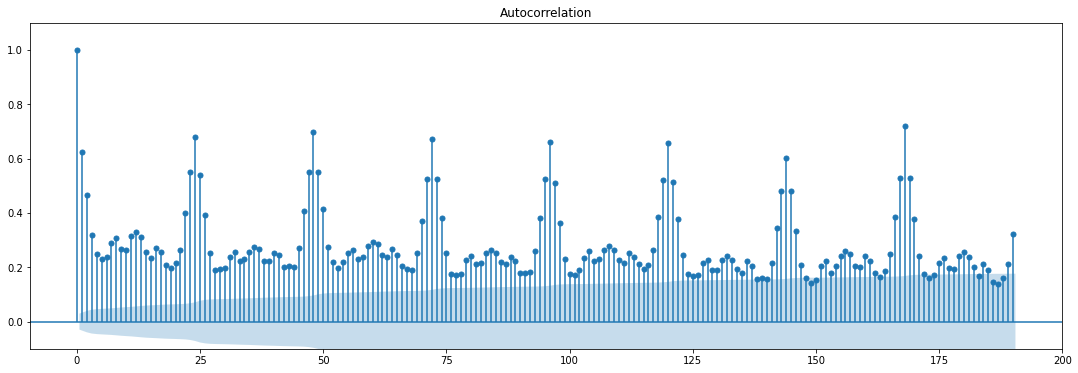

In [12]:
fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Разделим данные на обучающую и тестовую выборки. Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.
Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет. В предыдущих задачах значения этих признаков были NaN. Их нужно удалить.

In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Выделим признаки и целевой признак.

In [14]:
features_train = train.drop(['num_orders'],axis=1)# < напишите код здесь >
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

Напишем функцию для вычисления RMSE. В дальнейшем будем её применять в моделях машинного обучения.

In [15]:
def rmse(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
rmse_score = make_scorer(rmse, greater_is_better=False)

**Рассмотрим несколько моделей машинного обучения:**
- Линейную регрессию.
- Ridge.
- Lasso.
- CatBoostRegressor.

**Вычислим для каждой метрику RMSE и время обучения и предсказания модели. По этим данным будем выбирать лучшую модель.**

### Линейная регрессия.

In [16]:
%%time

tss = TimeSeriesSplit(n_splits=3)
model_lin = LinearRegression()
model_lin.fit(features_train, target_train)
rmse = cross_val_score(model_lin,features_train,target_train,scoring=rmse_score,cv=tss).mean()
print('RMSE для линейной регрессии:', -rmse)

RMSE для линейной регрессии: 23.077379405855833
CPU times: user 425 ms, sys: 887 ms, total: 1.31 s
Wall time: 1.28 s


### Ridge.

In [17]:
%%time

tss = TimeSeriesSplit(n_splits=3)
model_ridge = Ridge()
params_grid_rid = {'alpha':[1, 5, 10, 20]
             }
ridge_grid = GridSearchCV(model_ridge, params_grid_rid, scoring=rmse_score, cv=tss)
ridge_grid.fit(features_train, target_train)
print('Лучшее RMSE для Ridge:',-ridge_grid.best_score_, 'с гиперпараметрами:', ridge_grid.best_params_)

Лучшее RMSE для Ridge: 23.077373637482975 с гиперпараметрами: {'alpha': 20}
CPU times: user 945 ms, sys: 2.36 s, total: 3.31 s
Wall time: 3.31 s


### Lasso.

In [18]:
%%time

tss = TimeSeriesSplit(n_splits=3)
model_lasso = Lasso()
params_grid_rid = {'alpha':[1, 5, 10, 20]
             }
lasso_grid = GridSearchCV(model_lasso, params_grid_rid, scoring=rmse_score, cv=tss)
lasso_grid.fit(features_train, target_train)
print('Лучшее RMSE для Ridge:',-lasso_grid.best_score_, 'с гиперпараметрами:', lasso_grid.best_params_)

Лучшее RMSE для Ridge: 22.341867335916547 с гиперпараметрами: {'alpha': 20}
CPU times: user 1.78 s, sys: 3.74 s, total: 5.52 s
Wall time: 5.59 s


### CatBoostRegressor.

In [19]:
%%time

tss = TimeSeriesSplit(n_splits=3)
model_cat = CatBoostRegressor()
params_grid_cat = {'learning_rate': [0.05, 0.1],
                   'depth': [4, 6, 10]
                  }
cat_grid = GridSearchCV(model_cat, params_grid_cat, scoring=rmse_score, cv=tss)
cat_grid.fit(features_train, target_train, verbose=200)
print('Лучшее RMSE для CatBostRegressor:',-cat_grid.best_score_, 'с гиперпараметрами:', cat_grid.best_params_)

0:	learn: 28.9747894	total: 59.4ms	remaining: 59.4s
200:	learn: 12.8529332	total: 1.96s	remaining: 7.78s
400:	learn: 9.4693175	total: 3.83s	remaining: 5.72s
600:	learn: 7.1532946	total: 5.79s	remaining: 3.85s
800:	learn: 5.3720089	total: 7.79s	remaining: 1.94s
999:	learn: 4.0372075	total: 9.79s	remaining: 0us
0:	learn: 32.2922689	total: 19ms	remaining: 19s
200:	learn: 15.2761730	total: 2.58s	remaining: 10.2s
400:	learn: 12.8623586	total: 5.2s	remaining: 7.76s
600:	learn: 10.9875493	total: 7.59s	remaining: 5.04s
800:	learn: 9.4747090	total: 9.9s	remaining: 2.46s
999:	learn: 8.2222844	total: 12.2s	remaining: 0us
0:	learn: 33.1401755	total: 15.5ms	remaining: 15.5s
200:	learn: 16.8976607	total: 2.65s	remaining: 10.5s
400:	learn: 14.8387912	total: 5.33s	remaining: 7.95s
600:	learn: 13.2815798	total: 7.94s	remaining: 5.27s
800:	learn: 11.9332881	total: 10.6s	remaining: 2.63s
999:	learn: 10.7686045	total: 13.3s	remaining: 0us
0:	learn: 28.3136058	total: 10.7ms	remaining: 10.7s
200:	learn: 9.3

 Сведём все вычисленные метрики в одну таблицу для наглядного представления.

In [20]:
index = ['LinearRegression',
         'RidgeRegression',
         'LassoRegression',
         'CatBoostRegressor']
data = {'RMSE модели':[-rmse,
                       -ridge_grid.best_score_,
                       -lasso_grid.best_score_,
                       -cat_grid.best_score_]}

data_new = pd.DataFrame(data=data, index=index)
data_new

,RMSE модели
LinearRegression,23.077379
RidgeRegression,23.077374
LassoRegression,22.341867
CatBoostRegressor,23.630716


**Лучший результат метрики RMSE показывает Lasso с результатом 22,34. Незначительно проигрывают ей сразу 2 модели: линейная регрессия и Ridge, у них результат по 23,07. Проигрывает всем CatBoostRegressor так же незначительно, уступив остальным с показателем 23,63. По времени обучения CatBoostRegressor проигрывает всем с треском(32мин 32 сек.).По времени Lasso уступаем двум другим незначительно. Исходя из вышеперечисленно лучшей определю модель Lasso,опираясь на результат RMSE. Именно её рекомендую к использованию.**

## Тестирование

Протестируем лучшую модель на тестовых данных.Ей я вляется модель lasso с гиперпараметром alpha=20.

In [21]:
%%time

tss = TimeSeriesSplit(n_splits=3)
model_lasso_test = Lasso()
params_grid_rid_test = {'alpha':[20]
             }
lasso_grid_test = GridSearchCV(model_lasso, params_grid_rid, scoring=rmse_score, cv=tss)
lasso_grid_test.fit(features_test, target_test)
print('RMSE для Ridge на тестовой выборке:',-lasso_grid_test.best_score_)

RMSE для Ridge на тестовой выборке: 46.469365386275854
CPU times: user 1.1 s, sys: 3.32 s, total: 4.41 s
Wall time: 4.39 s


**Значение метрики RMSE на тестовой выборке 46,46. По заданию значение метрики RMSE на тестовой выборке должно быть не больше 48. Мы справились с этой задачей.**

## Общий вывод.

Нам была поставлена задача- нужно спрогнозировать количество заказов такси на следующий час,чтобы привлекать больше водителей в период пиковой нагрузки.

На этапе изучения и подготовки данных мы определили размерность исходной таблицы, интервал временного ряда,который составлял 10 минут и период, за который собраны данные.Он составил полгода. 
**Интервал временного ряда мы поменяли.** Согласно заданию выполнили ресемплирование **по одному часу.**

На этапе анализа данных мы разложили временной ряд на **тренд и сезонную компоненту.** Сделали выводы, что со временем количество заказов **растет.** Затем из за высокой частотности данных, мы рассмотрели данные на небольшом периоде, который составил 2 дня с 1 по 3 июля и период в 2 недели с 1 по 15 июля.Сделали выводы, что **количество заказов растет на выходных днях и в ночные часы.** Сезонность мы посмотреть не можем, так как данные собраны за полгода. Так же проверили приводим ли наш ряд к стационарному при помощи теста Дики-Фуллера.

На этапе обучения данных мы сначала подготовили данные для прогнозирования.Создали признаки для горизонта прогнозирования в один шаг. Написали функцию для создания календарных признаков. Разделили выборку на тренировочную и тестовую, которые в свою очередь раззделили на признаки и целевой признак. Далее выбрали несколько моделей машинного обучения для сравнения друг с другом. Какие модели были выбраны для исследования:
- Линейную регрессию.
- Ridge.
- Lasso.
- CatBoostRegressor.

Лучшей моделью была признана **модель Lasso** с результатом метрики RMSE-**22,34** и временем обучения и предсказания в **5,59 сек.**

На этапе тестирования модели проверили модель Lasso на тестовой выборки и достигли результата в **46,46** метрики RMSE, что ниже верхней границы по поставленной задаче в 48. 